In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import factorial
from scipy.special import eval_genlaguerre
import matplotlib
import csv

In [3]:
q1 = -np.array([0.0,-1.0],dtype = complex)  # lattice vectors in the Q lattice
q2 = -np.array([np.sqrt(3)/2,0.5],dtype = complex)
q3 = -np.array([-np.sqrt(3)/2,0.5],dtype = complex)

b1 = q2 - q1
b2 = q3 - q1

# Lattice vectors
a1 = (2./3)*np.array([-np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice
a2 = (2./3)*np.array([np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice

# special points in the MBZ
kpt = 2*np.pi*q3 # The K point
gpt = 2*np.pi*np.array([0.0,0.0], dtype = complex) # The Gamma point
mpt = 2*np.pi*q3 + 0.5*2*np.pi*q1 # The M point
mmpt = -mpt
kppt = -kpt

# 3 parameters  
w0 = 0.8/np.sqrt(3)
w1 = 1./np.sqrt(3)
vFkth = 186.8 # true magic angle

In [4]:
ax1, ay1 = a1
ax2, ay2 = a2
omega = abs(ax1 * ay2 - ay1 * ax2)
    
z1 = (ax1 + 1.0j*ay1)/np.sqrt(omega)
z1bar = (ax1 - 1.0j*ay1)/np.sqrt(omega)
z2 = (ax2 + 1.0j*ay2)/np.sqrt(omega)
z2bar = (ax2 - 1.0j*ay2)/np.sqrt(omega)

In [5]:
def distance(a,b): # finds the distance between two complex vectors
    x0, y0 = np.real(a) # because they were complex, cast to real and then unpack to get x, y
    x1, y1 = np.real(b)
    return(np.sqrt((x0-x1)**2 + (y0 - y1)**2))

In [6]:
formFactors1 = np.zeros((100,100),dtype=complex)
formFactors2 = np.zeros((100,100),dtype=complex)

file1 = open('./TBG_1.csv', 'r')
for j,line in enumerate(file1.readlines()):
    formFactors1[j] = [complex(i.replace('*^','e').replace('*I','j')) for i in line.split(',')]
    
file2 = open('./TBG_2.csv', 'r')
for j,line in enumerate(file2.readlines()):
    formFactors2[j] = [complex(i.replace('*^','e').replace('*I','j')) for i in line.split(',')]

In addition to the kinetic terms, we add the PH-breaking term

In [11]:
num_landau = 80
energy = np.sqrt((3*np.sqrt(3))/(2*np.pi))
kinetic_1 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex) # layer 1
kinetic_2 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex) # layer 2

# First we add the kinetic terms
for m in range(-num_landau,num_landau+1): 
    kinetic_1[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)
    kinetic_2[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)

# And then the shifts from the change of basis    
for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m)-1 == abs(n)):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = 0.5j*np.sign(m)*coeff
            kinetic_1[m][n] = -0.5j*np.sign(m)*coeff
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = -0.5j*np.sign(n)*coeff
            kinetic_1[m][n] = 0.5j*np.sign(n)*coeff
            
# Now the new terms
kinetic_shift_1 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
kinetic_shift_2 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

# Calculate the shifted kinetic additions
thetaRad = 1.05*np.pi/180.0 # twist angle in radians
sTheta = np.sin(thetaRad/2.)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m) == abs(n)):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            
            kinetic_shift_1[m][n] += energy*(thetaRad/2.)*coeff*\
                     (-1.0j*np.sign(m) * np.sqrt(abs(n)) + 1.0j*np.sign(n)*np.sqrt(abs(n)))
            
            kinetic_shift_2[m][n] += -energy*(thetaRad/2.)*coeff*\
                     (-1.0j*np.sign(m) * np.sqrt(abs(n)) + 1.0j*np.sign(n)*np.sqrt(abs(n)))

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m)-1 == abs(n)):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_shift_2[m][n] += -0.5*np.sign(m)*coeff*thetaRad/2.
            kinetic_shift_1[m][n] += -0.5*np.sign(m)*coeff*thetaRad/2.
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_shift_2[m][n] += -0.5*np.sign(n)*coeff*thetaRad/2.
            kinetic_shift_1[m][n] += -0.5*np.sign(n)*coeff*thetaRad/2.
            


In [12]:
# now the T-matrices, but the k-dependence is factored out
t1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t3_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):            
        coe = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            
        t2_matrix[m][n] += coe*w0*formFactors1[abs(m),abs(n)]
        t3_matrix[m][n] += coe*w0*formFactors2[abs(m),abs(n)]
            
        if abs(n) > 0 and abs(m) > 0:
            t2_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors1[abs(m)-1,abs(n)-1]
            t3_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors2[abs(m)-1,abs(n)-1]

        if abs(n) > 0:
            t2_matrix[m][n] += np.sign(n)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors1[abs(m),abs(n)-1]
            t3_matrix[m][n] += np.sign(n)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors2[abs(m),abs(n)-1]

        if abs(m) > 0:
            t2_matrix[m][n] += np.sign(m)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors1[abs(m)-1,abs(n)]
            t3_matrix[m][n] += np.sign(m)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors2[abs(m)-1,abs(n)]

        if abs(m) == abs(n):
            t1_matrix[m][n] += w0*coe
            if abs(m) != 0:
                t1_matrix[m][n] += w0*coe*np.sign(m*n)
                    
        if abs(m)-1 == abs(n) and abs(m) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(m)
                
        if abs(n)-1 == abs(m) and abs(n) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(n)

def generateHam(k):
    k1 = np.dot(a1,k)
    k2 = np.dot(a2,k)
    t_mat = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
    t_mat = t1_matrix + np.exp(-1.0j*k2) * t2_matrix + np.exp(1.0j*k1) *t3_matrix
    hamiltonian = np.block([[kinetic_1+kinetic_shift_1, t_mat], [t_mat.conj().T, kinetic_2+kinetic_shift_2]])
    return(vFkth*hamiltonian)

In [13]:
# generate path in MBZ to plot
numpoints = 50 # path divided into pieces.  There are 3*numpoints, from K to Gamma to M to K
g_to_k = [gpt * (1.0 - (t+0.0)/numpoints) + kpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from K to Gamma
k_to_m = [kpt * (1.0 - (t+0.0)/numpoints) + mpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from Gamma to M
m_to_g = [mpt * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from M to K
g_to_mm = [gpt * (1.0 - (t+0.0)/numpoints) + mmpt * ((t+0.0)/numpoints) for t in range(numpoints)]
mm_to_kp = [mmpt * (1.0 - (t+0.0)/numpoints) + kppt * ((t+0.0)/numpoints) for t in range(numpoints)]

list_of_points = g_to_k+k_to_m+m_to_g+g_to_mm+mm_to_kp # + means append here, so the list is 3*numpoints long
array_of_points = np.array(list_of_points) # to numpy array

# some intervals between points are longer than others.  Fix by normalizing by length
len_k = [0.0] # this is the x-axis of the band structure plot.  starting at 0,
prev_k = 0.0
for i in range(len(list_of_points) - 1):
    prev_k += distance(array_of_points[i+1],array_of_points[i]) # add distances cumulatively
    len_k.append(prev_k)

In [14]:
listOfEigenvals = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

In [24]:
totalEigs = []
for i in range(150):
    for j in range(150):
        k_vec = 2*np.pi*b1*j/150.0+2*np.pi*b2*i/150.0
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
        totalEigs.append(eigenvals[158:164])   

In [25]:
#total = np.array(totalEigs).flatten()
np.save('PH-breaking_histogram.npy',np.array(totalEigs))

In [26]:
listOfPointsForBZ = []
for i1 in range(150):    
    for j1 in range(150):
        k_vec = 2*np.pi*i1/150.0*b1 + 2*np.pi*j1/150.0*b2
        listOfPointsForBZ.append(k_vec)

arrayOfPointsForBZ = np.array(listOfPointsForBZ)
arrayOfEigsForBZ = np.array(totalEigs)

In [27]:
def plotHexagon(points,l1,l2):
    # first, translate the states into the hexagon
    # define the unit vectors that define the hexagon
    dist = np.linalg.norm(l1)
    hex1 = l1/np.linalg.norm(l1)
    hex2 = l2/np.linalg.norm(l2)
    l3 = l2 - l1
    hex3 = l3/np.linalg.norm(l3)
    newPoints = []
    for coords in points:
        len1 = np.dot(coords, hex1)
        len2 = np.dot(coords, hex2)
        len3 = np.dot(coords, hex3)
        if len1 < 0.5*dist+0.00005 and len2 < 0.5*dist+0.00005:
            newPoints.append(coords)
        elif len1 > dist and len2 > dist:
            newPoints.append(coords-l1-l2)
        elif len3 > 0:
            newPoints.append(coords-l2)
        else:
            newPoints.append(coords-l1)
            
    return(np.array(newPoints))

In [43]:
def inHexagon(pointsx,pointsy,l1,l2):
    # first, translate the states into the hexagon
    # define the unit vectors that define the hexagon
    matrixOfVals = np.zeros(np.shape(pointsx))
    dist = np.linalg.norm(l1)
    hex1 = l1/np.linalg.norm(l1)
    hex2 = l2/np.linalg.norm(l2)
    l3 = l2 - l1
    hex3 = l3/np.linalg.norm(l3)
    inside = []
    for i in range(len(pointsx)):
        for j in range(len(pointsx[0])):
            matrixOfVals[i][j] = 0
            coords = np.array([pointsx[i][j],pointsy[i][j]])
            len1 = np.dot(coords, hex1)
            len2 = np.dot(coords, hex2)
            len3 = np.dot(coords, hex3)
            if len1 < 2*np.pi*np.sqrt(3)/2 and len1 > -2*np.pi*np.sqrt(3)/2:
                if len2 < 2*np.pi*np.sqrt(3)/2 and len2 > -2*np.pi*np.sqrt(3)/2:
                    if len3 < 2*np.pi*np.sqrt(3)/2 and len3 > -2*np.pi*np.sqrt(3)/2:
                        matrixOfVals[i][j] = 1.0
    return(matrixOfVals)

/usr/local/lib/python3.8/site-packages/scipy/interpolate/ndgriddata.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  xi = _ndim_coords_from_arrays(args, ndim=self.points.shape[1])
/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.8/site-packages/matplotlib/transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


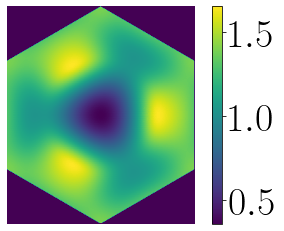

In [44]:
import scipy.interpolate

newCoords = plotHexagon(np.real(arrayOfPointsForBZ),2*np.pi*b1,2*np.pi*b2)
x = newCoords[:,0]
y = newCoords[:,1]
z = arrayOfEigsForBZ[:,2]
pts = np.real(newCoords)
# Set up a regular grid of interpolation points
xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
xi, yi = np.meshgrid(xi, yi)
# Interpolate
newguess = scipy.interpolate.NearestNDInterpolator(pts,z)
zi = np.multiply(inHexagon(xi,yi,2*np.pi*b1,2*np.pi*b2),newguess(xi, yi))
plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.axis('off')

#plt.scatter(x, y, c=z)
plt.colorbar()
plt.savefig('PH_breaking_band_1_heatmap.png')

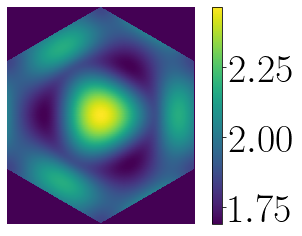

In [45]:
import scipy.interpolate

newCoords = plotHexagon(np.real(arrayOfPointsForBZ),2*np.pi*b1,2*np.pi*b2)
x = newCoords[:,0]
y = newCoords[:,1]
z = arrayOfEigsForBZ[:,3]
pts = np.real(newCoords)
# Set up a regular grid of interpolation points
xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
xi, yi = np.meshgrid(xi, yi)
# Interpolate
newguess = scipy.interpolate.NearestNDInterpolator(pts,z)
zi = np.multiply(inHexagon(xi,yi,2*np.pi*b1,2*np.pi*b2),newguess(xi, yi))
plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.axis('off')

#plt.scatter(x, y, c=z)
plt.colorbar()
plt.savefig('PH_breaking_band_2_heatmap.png')

In [35]:
# create the Z_matrix
num_landau = 80
z1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
z2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
zeros = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m) == abs(n)+1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m)))) * 1.0/np.sqrt(4*np.pi)
            z1_matrix[m][n] += z1*(np.sqrt(abs(n) + 1) + np.sign(m*n)*np.sqrt(abs(n)))*coeff
            z2_matrix[m][n] += z2*(np.sqrt(abs(n) + 1) + np.sign(m*n)*np.sqrt(abs(n)))*coeff
            
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m)))) * 1.0/np.sqrt(4*np.pi)
            z1_matrix[m][n] += z1bar*(np.sqrt(abs(n)) + np.sign(m*n)*np.sqrt(abs(n) - 1))*coeff
            z2_matrix[m][n] += z2bar*(np.sqrt(abs(n)) + np.sign(m*n)*np.sqrt(abs(n) - 1))*coeff

z1_total_mat = np.block([[z1_matrix,zeros],[zeros,z1_matrix]])
z2_total_mat = np.block([[z2_matrix,zeros],[zeros,z2_matrix]])

In [36]:
expm_mat = sp.linalg.expm(1.0j*2*np.pi/150.0*z1_total_mat)
        
def getWilsonSpectrum(path):
    k_old = path[0]
    for j1, k_vec in enumerate(path):
        #k_diff = k_vec-k_old
        #k1 = np.dot(k_diff,a1)
        #k2 = np.dot(k_diff,a2)
        
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues        
        u_matrix_f1 = eigenvecs[:,160] # flat bands for wilson loop
        u_matrix_f2 = eigenvecs[:,161] # flat bands for wilson loop
        u_matrix_p1 = eigenvecs[:,162] # first passive band
        u_matrix_p2 = eigenvecs[:,163] # second passibe band
        u_matrix_m1 = eigenvecs[:,159] # first negative passive band
        u_matrix_m2 = eigenvecs[:,158] # second negative passive band
        u_matrix = eigenvecs[:,160:162]
        
        if j1 == 0:
            w_last = u_matrix
            w_first = u_matrix.conj().T            
            w_last_p1 = u_matrix_p1
            w_first_p1 = u_matrix_p1.conj().T
            w_last_p2 = u_matrix_p2
            w_first_p2 = u_matrix_p2.conj().T
            w_last_m1 = u_matrix_m1
            w_first_m1 = u_matrix_m1.conj().T
            w_last_m2 = u_matrix_m2
            w_first_m2 = u_matrix_m2.conj().T
            w_last_f1 = u_matrix_f1
            w_first_f1 = u_matrix_f1.conj().T            
            w_last_f2 = u_matrix_f2
            w_first_f2 = u_matrix_f2.conj().T            
            
        else:
            w_last = np.dot(u_matrix, np.dot( u_matrix.conj().T, np.dot(expm_mat, w_last)))
            w_last_p1 = np.dot(u_matrix_p1, np.dot(u_matrix_p1.conj().T, np.dot(expm_mat, w_last_p1)))
            w_last_p2 = np.dot(u_matrix_p2, np.dot(u_matrix_p2.conj().T, np.dot(expm_mat, w_last_p2)))
            w_last_m1 = np.dot(u_matrix_m1, np.dot(u_matrix_m1.conj().T, np.dot(expm_mat, w_last_m1)))
            w_last_m2 = np.dot(u_matrix_m2, np.dot(u_matrix_m2.conj().T, np.dot(expm_mat, w_last_m2)))
            w_last_f1 = np.dot(u_matrix_f1, np.dot(u_matrix_f1.conj().T, np.dot(expm_mat, w_last_f1)))
            w_last_f2 = np.dot(u_matrix_f2, np.dot( u_matrix_f2.conj().T, np.dot(expm_mat, w_last_f2)))

            #w_first = np.dot(np.dot(np.dot(w_first,expm_mat), u_matrix),u_matrix.conj().T)
            #w_first_f1 = np.dot(np.dot(np.dot(w_first_f1,expm_mat), u_matrix_f1),u_matrix_f1.conj().T)
            #w_first_f2 = np.dot(np.dot(np.dot(w_first_f2,expm_mat), u_matrix_f2),u_matrix_f2.conj().T)
            #w_first_p1 = np.dot(np.dot(np.dot(w_first_p1,expm_mat), u_matrix_p1),u_matrix_p1.conj().T)
            #w_first_p2 = np.dot(np.dot(np.dot(w_first_p2,expm_mat), u_matrix_p2),u_matrix_p2.conj().T)
            #w_first_m1 = np.dot(np.dot(np.dot(w_first_m1,expm_mat), u_matrix_m1),u_matrix_m1.conj().T)
            #w_first_m2 = np.dot(np.dot(np.dot(w_first_m2,expm_mat), u_matrix_m2),u_matrix_m2.conj().T)
        
        #k_old = k_vec
        
    return(np.dot(w_first_f1,np.dot(expm_mat,w_last_f1)), np.dot(w_first_f2,np.dot(expm_mat,w_last_f2)), \
           np.dot(w_first_p1,np.dot(expm_mat,w_last_p1)),np.dot(w_first_p2,np.dot(expm_mat,w_last_p2)),\
            np.dot(w_first_m1,np.dot(expm_mat,w_last_m1)),np.dot(w_first_m2,np.dot(expm_mat,w_last_m2)),\
           np.dot(w_first,np.dot(expm_mat,w_last)))

In [40]:
path_k1 = [[2*np.pi*b1*(j)/150.0+(2*np.pi*b2)*i/150.0 for i in range(150)] for j in range(151)]
listOfwMf1 = []
listOfwMf2 = []
listOfwMp1 = []
listOfwMp2 = []
listOfwMm1 = []
listOfwMm2 = []
listOfwM = []

for path in path_k1:
    wMf1,wMf2,wMp1,wMp2,wMm1,wMm2, wM = getWilsonSpectrum(path)
    listOfwMf1.append(-1.0j*np.log(wMf1))
    listOfwMf2.append(-1.0j*np.log(wMf2))
    listOfwMp1.append(-1.0j*np.log(wMp1))
    listOfwMp2.append(-1.0j*np.log(wMp2))
    listOfwMm1.append(-1.0j*np.log(wMm1))
    listOfwMm2.append(-1.0j*np.log(wMm2))
    eigval,eigvec = np.linalg.eig(np.matrix(wM))
    listOfwM.append(-1.0j*np.log(eigval))
    
arrayOfwMf1 = np.array(listOfwMf1)
arrayOfwMf2 = np.array(listOfwMf2)
arrayOfwMp1 = np.array(listOfwMp1)
arrayOfwMp2 = np.array(listOfwMp2)
arrayOfwMm1 = np.array(listOfwMm1)
arrayOfwMm2 = np.array(listOfwMm2)
arrayOfwM = np.array(listOfwM)

In [41]:
np.save('path_k1_f1_Wilson.npy',arrayOfwMf1)
np.save('path_k1_f2_Wilson.npy',arrayOfwMf2)
np.save('path_k1_p1_Wilson.npy',arrayOfwMp1)
np.save('path_k1_p2_Wilson.npy',arrayOfwMp2)
np.save('path_k1_m1_Wilson.npy',arrayOfwMm1)
np.save('path_k1_m2_Wilson.npy',arrayOfwMm2)
np.save('path_k1_fbs_Wilson.npy',arrayOfwM)

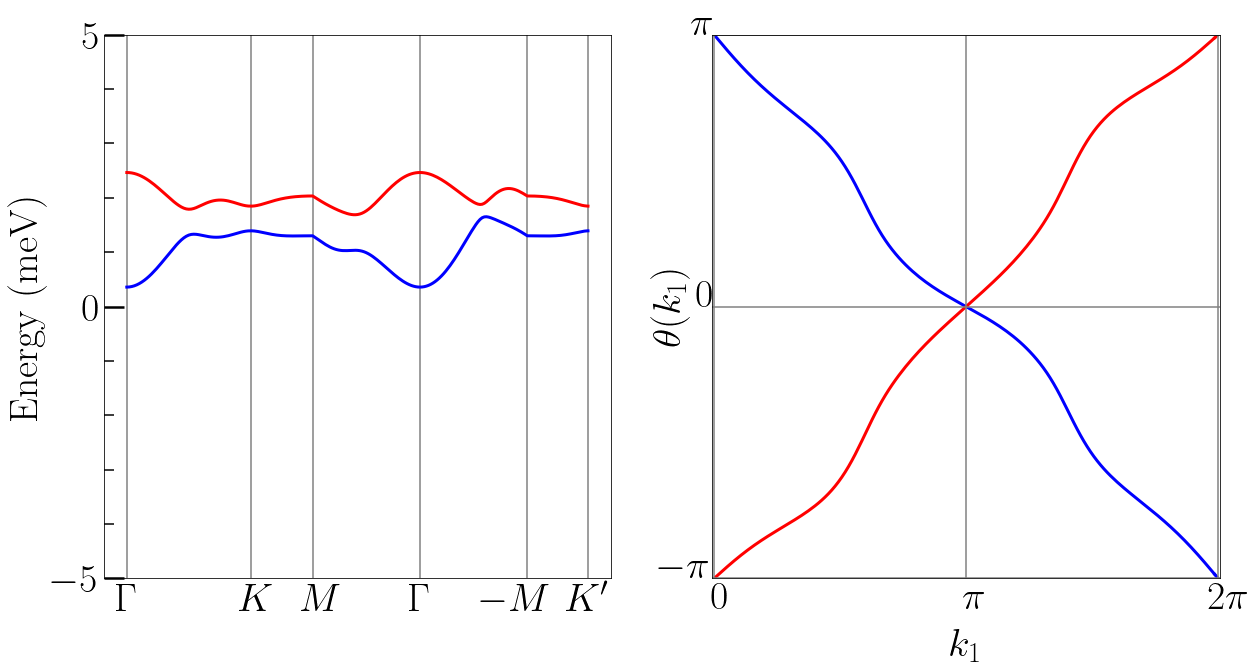

In [65]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), gridspec_kw={'width_ratios': [1,1]})
plt.subplots_adjust(wspace=0.2)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=180)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0],color='gray')
axes[0].text(len_k[0]-.55,-5.6,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[50],color='gray')
axes[0].text(len_k[50]-.65,-5.6,r'$K$',rotation=0)
axes[0].axvline(x=len_k[100],color='gray')
axes[0].text(len_k[100]-.65,-5.6,r'$M$',rotation=0)
axes[0].axvline(x=len_k[150],color='gray')
axes[0].text(len_k[150]-.55,-5.6,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[200],color='gray')
axes[0].text(len_k[200]-2.4,-5.6,r'$-M$',rotation=0)
axes[0].axvline(x=len_k[249],color='gray')
axes[0].text(len_k[249]-1.15,-5.6,r"$K'$",rotation=0)
axes[0].set_ylim([-5, 5])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

axes[0].set_ylabel(r'Energy (meV)')
axes[0].plot(len_k, arrayOfEigenvals[:,160],linewidth=3,color='blue')
axes[0].plot(len_k, arrayOfEigenvals[:,161],linewidth=3,color='red')
    

axes[0].get_yaxis().set_major_locator(MultipleLocator(5))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(1))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)


values0=np.mod(np.real(arrayOfwMf1) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)
values1=np.mod(np.real(arrayOfwMf2) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)

#plt.plot([0,1], [values0[0],values0[1]+2*np.pi],c='blue',linewidth=3) 
#plt.plot([0,1], [values1[0],values1[1]-2*np.pi],c='red',linewidth=3) 

plt.plot(range(151)[:150], values0[:150],c='blue',linewidth=3) 
plt.plot(range(151)[149:151], [values0[149],values0[150]-2*np.pi],c='blue',linewidth=3) 

plt.plot(range(151)[:150], values1[:150],c='red',linewidth=3) 
plt.plot(range(151)[149:151], [values1[149],values1[150]+2*np.pi],c='red',linewidth=3) 

axes[1].tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
axes[1].tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

axes[1].axhline(y=0,color='gray')
axes[1].axhline(y=np.pi,color='gray')
axes[1].axhline(y=2*np.pi,color='gray')

axes[1].text(-16.75,0,r'$-\pi$',rotation=0)
axes[1].text(-5.5,np.pi,r'$0$',rotation=0)
axes[1].text(-6.75,2*np.pi,r'$\pi$',rotation=0)

axes[1].axvline(x=0,color='gray')
axes[1].axvline(x=75,color='gray')
axes[1].axvline(x=150,color='gray')

axes[1].text(0-1,-0.35,r'$0$',rotation=0)
axes[1].text(75-1,-0.35,r'$\pi$',rotation=0)
axes[1].text(150-3,-0.35,r'$2\pi$',rotation=0)
axes[1].set_xlim([-0.5,150.5])
axes[1].set_ylim([0.0,2*np.pi])

axes[1].set_ylabel(r'$\theta(k_1)$',labelpad=22)
axes[1].set_xlabel(r'$k_1$',labelpad=50)
#ax = axes[3].subplot(111)
#ax.set_frame_on(False)
axes[1].tick_params(left=False)

plt.savefig('PH_twist_zoomed_1-05.png',bbox_inches='tight')

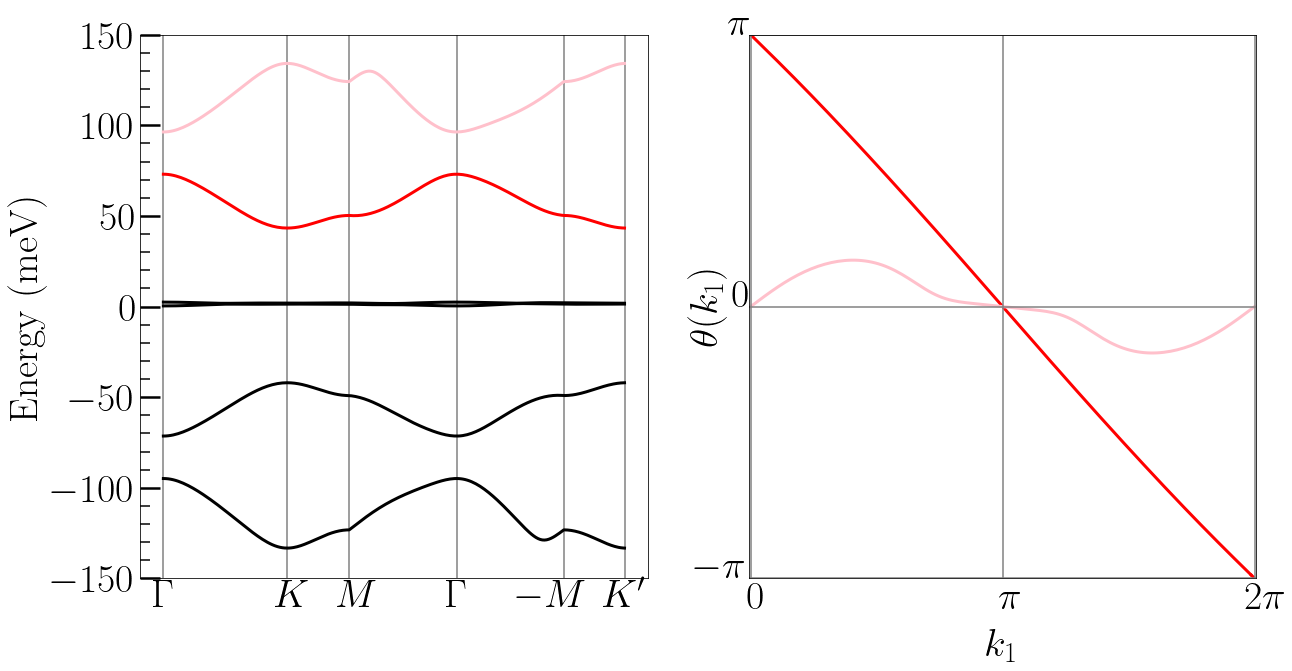

In [61]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), gridspec_kw={'width_ratios': [1,1]})
plt.subplots_adjust(wspace=0.2)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=180)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0],color='gray')
axes[0].text(len_k[0]-.55,-6-160,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[50],color='gray')
axes[0].text(len_k[50]-.65,-6-160,r'$K$',rotation=0)
axes[0].axvline(x=len_k[100],color='gray')
axes[0].text(len_k[100]-.65,-6-160,r'$M$',rotation=0)
axes[0].axvline(x=len_k[150],color='gray')
axes[0].text(len_k[150]-.55,-6-160,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[200],color='gray')
axes[0].text(len_k[200]-2-.4,-6-160,r'$-M$',rotation=0)
axes[0].axvline(x=len_k[249],color='gray')
axes[0].text(len_k[249]-1-.15,-6-160,r"$K'$",rotation=0)
axes[0].set_ylim([-150, 150])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

axes[0].set_ylabel(r'Energy (meV)')
axes[0].plot(len_k, arrayOfEigenvals[:,160],linewidth=3,color='black')
axes[0].plot(len_k, arrayOfEigenvals[:,161],linewidth=3,color='black')
axes[0].plot(len_k, arrayOfEigenvals[:,159],linewidth=3,color='black')
axes[0].plot(len_k, arrayOfEigenvals[:,158],linewidth=3,color='black')
axes[0].plot(len_k, arrayOfEigenvals[:,162],linewidth=3,color='red')
axes[0].plot(len_k, arrayOfEigenvals[:,163],linewidth=3,color='pink')
    

axes[0].get_yaxis().set_major_locator(MultipleLocator(50))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(10))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)


values0=np.mod(np.real(arrayOfwMp1) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)
values1=np.mod(np.real(arrayOfwMp2) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)
values2=np.mod(np.real(arrayOfwMm1) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)
values3=np.mod(np.real(arrayOfwMm2) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)

plt.plot(range(151)[:150], values0[:150],c='red',linewidth=3)
plt.plot(range(151)[149:151], [values0[149],values0[150]-2*np.pi],c='red',linewidth=3)


plt.plot(range(151), values1,c='pink',linewidth=3) 


axes[1].tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
axes[1].tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

axes[1].axhline(y=0,color='gray')
axes[1].axhline(y=np.pi,color='gray')
axes[1].axhline(y=2*np.pi,color='gray')

axes[1].text(-16.75,0,r'$-\pi$',rotation=0)
axes[1].text(-5.5,np.pi,r'$0$',rotation=0)
axes[1].text(-6.75,2*np.pi,r'$\pi$',rotation=0)

axes[1].axvline(x=0,color='gray')
axes[1].axvline(x=75,color='gray')
axes[1].axvline(x=150,color='gray')

axes[1].text(0-1,-0.35,r'$0$',rotation=0)
axes[1].text(75-1,-0.35,r'$\pi$',rotation=0)
axes[1].text(150-3,-0.35,r'$2\pi$',rotation=0)
axes[1].set_xlim([-0.5,150.5])
axes[1].set_ylim([0.0,2*np.pi])

axes[1].set_ylabel(r'$\theta(k_1)$',labelpad=22)
axes[1].set_xlabel(r'$k_1$',labelpad=50)
#ax = axes[3].subplot(111)
#ax.set_frame_on(False)
axes[1].tick_params(left=False)

plt.savefig('PH_twist_zoomed_1-05_passive_positive.png',bbox_inches='tight')

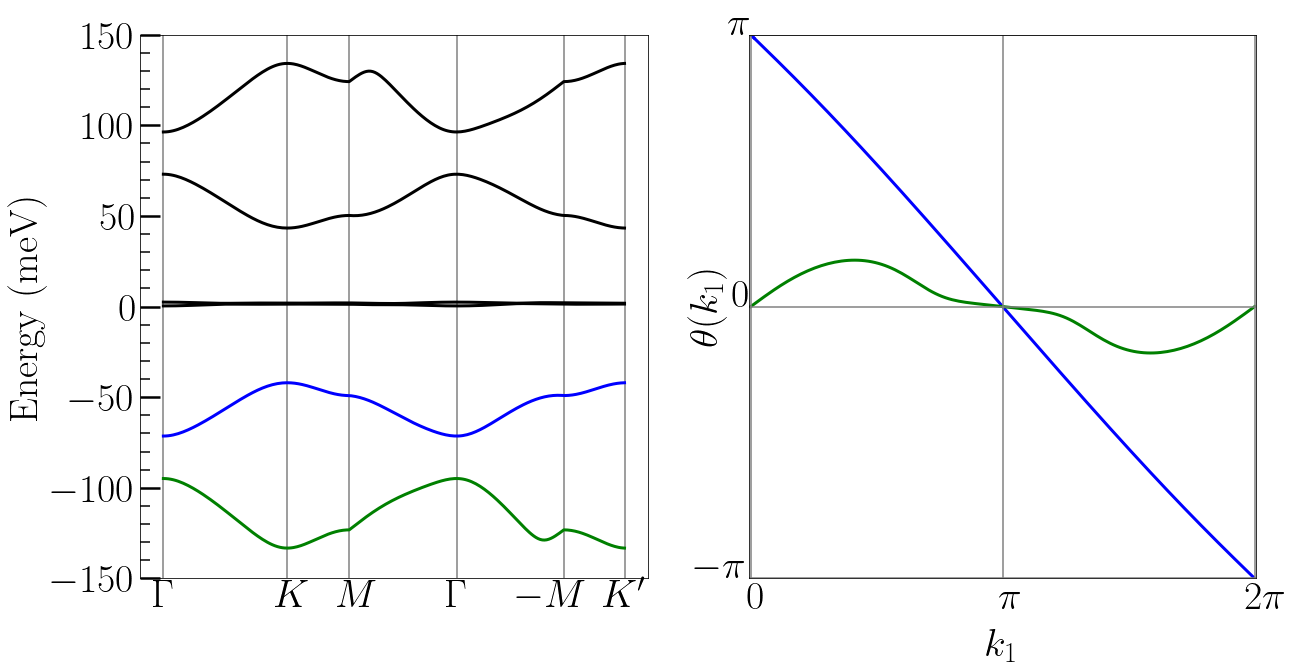

In [62]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), gridspec_kw={'width_ratios': [1,1]})
plt.subplots_adjust(wspace=0.2)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=180)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0],color='gray')
axes[0].text(len_k[0]-.55,-6-160,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[50],color='gray')
axes[0].text(len_k[50]-.65,-6-160,r'$K$',rotation=0)
axes[0].axvline(x=len_k[100],color='gray')
axes[0].text(len_k[100]-.65,-6-160,r'$M$',rotation=0)
axes[0].axvline(x=len_k[150],color='gray')
axes[0].text(len_k[150]-.55,-6-160,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[200],color='gray')
axes[0].text(len_k[200]-2-.4,-6-160,r'$-M$',rotation=0)
axes[0].axvline(x=len_k[249],color='gray')
axes[0].text(len_k[249]-1-.15,-6-160,r"$K'$",rotation=0)
axes[0].set_ylim([-150, 150])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

axes[0].set_ylabel(r'Energy (meV)')
axes[0].plot(len_k, arrayOfEigenvals[:,160],linewidth=3,color='black')
axes[0].plot(len_k, arrayOfEigenvals[:,161],linewidth=3,color='black')
axes[0].plot(len_k, arrayOfEigenvals[:,159],linewidth=3,color='blue')
axes[0].plot(len_k, arrayOfEigenvals[:,158],linewidth=3,color='green')
axes[0].plot(len_k, arrayOfEigenvals[:,162],linewidth=3,color='black')
axes[0].plot(len_k, arrayOfEigenvals[:,163],linewidth=3,color='black')
    

axes[0].get_yaxis().set_major_locator(MultipleLocator(50))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(10))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)


values0=np.mod(np.real(arrayOfwMm1) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)
values1=np.mod(np.real(arrayOfwMm2) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)

#plt.plot([0,1], [values0[0],values0[1]+2*np.pi],c='blue',linewidth=3) 
#plt.plot([0,1], [values1[0],values1[1]-2*np.pi],c='red',linewidth=3) 

plt.plot(range(151)[1:], values0[1:],c='blue',linewidth=3)
plt.plot(range(151)[0:2], [values0[0]+2*np.pi,values0[1]],c='blue',linewidth=3)

plt.plot(range(151), values1,c='green',linewidth=3) 
#plt.plot(range(151), values2,c='blue',linewidth=3) 
#plt.plot(range(151), values3,c='green',linewidth=3) 

axes[1].tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
axes[1].tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

axes[1].axhline(y=0,color='gray')
axes[1].axhline(y=np.pi,color='gray')
axes[1].axhline(y=2*np.pi,color='gray')

axes[1].text(-16.75,0,r'$-\pi$',rotation=0)
axes[1].text(-5.5,np.pi,r'$0$',rotation=0)
axes[1].text(-6.75,2*np.pi,r'$\pi$',rotation=0)

axes[1].axvline(x=0,color='gray')
axes[1].axvline(x=75,color='gray')
axes[1].axvline(x=150,color='gray')

axes[1].text(0-1,-0.35,r'$0$',rotation=0)
axes[1].text(75-1,-0.35,r'$\pi$',rotation=0)
axes[1].text(150-3,-0.35,r'$2\pi$',rotation=0)
axes[1].set_xlim([-0.5,150.5])
axes[1].set_ylim([0.0,2*np.pi])

axes[1].set_ylabel(r'$\theta(k_1)$',labelpad=22)
axes[1].set_xlabel(r'$k_1$',labelpad=50)
#ax = axes[3].subplot(111)
#ax.set_frame_on(False)
axes[1].tick_params(left=False)

plt.savefig('PH_twist_zoomed_1-05_passive_negative.png',bbox_inches='tight')